In [1]:
#Libraries
using Gen
using PyPlot
using Distributions
using LinearAlgebra
#using Flux

In [2]:
#Hyperparameters
n = 500
k_range = 7
k_list = [i for i in 1:k_range];

In [2]:
#Structure for generating some data and a discriminant polynomial
struct Poly
    β::Array{Float64}
    degree::Int
    x::Array{Float64}
    y::Array{Float64}
end

function fit_poly(f::Poly, x::Array)
    fitted_y = [sum([f.β[j]*x[i]^(j-1) for j=1:f.degree]) for i=1:length(x)]
    return fitted_y
end

function make_poly(β::Array{Float64}, N=5000::Int)
    degree = length(β)
    x = [2*(i/N - 0.5) for i=1:N]
    y = [sum([β[j]*x[i]^(j-1) for j=1:degree]) for i=1:length(x)]
    return(Poly(β, degree, x, y))
end

function plot_poly(f::Poly, c="black"::String, a=1.0::Float64,z=5::Int)
    plot(f.x, f.y, color=c,alpha=a,zorder=z)
    ax=gca()
    ax[:set_ylim]([-1.0,1.0])
end

function data_labeller(x::Array{Float64},y::Array{Float64},f::Poly)
    fitted_y = fit_poly(f, x)
    labels = [y[i] > fitted_y[i] ? 2 : 1 for i=1:length(x)]
    return labels
end

function make_data(f::Poly, N=5000::Int)
    a = minimum(f.y)
    b = maximum(f.y)
    x = rand(Uniform(-1,1),N)
    y = rand(Uniform(a,b),N)
    return (x,y)
end

function plot_data(x::Array{Float64},y::Array{Float64},f::Poly)
    labels = data_labeller(x,y,f)
    markers = ["o","*"]
    colors = ["blue","green"]
    for i=1:2
        mask = [labels[j] == i for j in 1:length(y)]
        scatter(x[mask],y[mask],c=colors[i],marker=markers[i],zorder=3)
    end
    plot_poly(f)
end

function plot_accuracy(x::Array{Float64},y::Array{Float64},f::Poly,f_new::Poly)
    true_labels = data_labeller(x,y,f)
    pred_labels = data_labeller(x,y,f_new)
    correct = [pred_labels[i] == true_labels[i] for i in 1:length(x)]
    plot_poly(f)
    plot_poly(f_new, "blue")
    scatter(x,y,c=correct,cmap="Set1")
end

function sigmoid(x::Array{Float64})
    return 1.0 ./ (1.0 .+ exp.(-x))
end

#function sigmoid(x::Array{ReverseDiff.TrackedReal{Float64,Float64,Nothing},1})
        
#end

β_test = [0.0,0.,-0.0,1.0]
f_test = make_poly(β_test, 100)
x_test, y_test = make_data(f_test, n)
plot_data(x_test,y_test,f_test)

function test_sigmoid(x::Array{Float64},y::Array{Float64},f)
    fitted = fit_poly(f,x)
    labels = data_labeller(x,y,f)
    differences = y - fitted
    println(sum(differences))
    scores = sigmoid(differences)
    scatter(differences, scores)
    classes = [scores[i] >= 0.5 ? 2 : 1 for i in 1:length(scores)]
    correct = [classes[i] == labels[i] for i in 1:length(classes)]
    println(sum(correct)/length(correct))
end;

UndefVarError: UndefVarError: n not defined

In [1]:
#The model
@gen function blr(x,y,f,fixed_k=4)
    σₖ = 1 #Sigma hyperparameter for drawing coefficients
    
    #if fixed_k == 0
        #k ~ uniform_discrete(1,7) #Degree of the polynomial
    #else
        #k = fixed_k
    #end
    k=fixed_k
    
    μ = zeros(k)
    Σ = Diagonal([σₖ for i=1:k])
    β ~ mvnormal(μ,Σ) #Coefficients of the polynomial
    
    #f₂ = make_poly(β)
    #fitted_values = fit_poly(f₂,x)
    fitted_values = [sum([β[j]*x[i]^(j-1) for j=1:k]) for i=1:length(x)]
    τ = 1/0.005 #Scale parameter for differences
    ϵ = (y - fitted_values)*τ
    #scores = σ.(ϵ)
    scores=sigmoid(ϵ)

    z = zeros(length(x)) #Array to fill with class labels
    for j in 1:length(x)
        z[j] = @trace(categorical([1-scores[j],scores[j]]), (:z,j))
        #Draw class labels from Bernoulli distribution based on p = sigmoid(differences)
    end
    return z
end;

LoadError: UndefVarError: @gen not defined

In [14]:
#Register Observed Data
labels = data_labeller(x_test,y_test,f_test)
obs = choicemap()::ChoiceMap
for j in 1:length(x_test)
    obs[(:z, j)] = labels[j]
end;

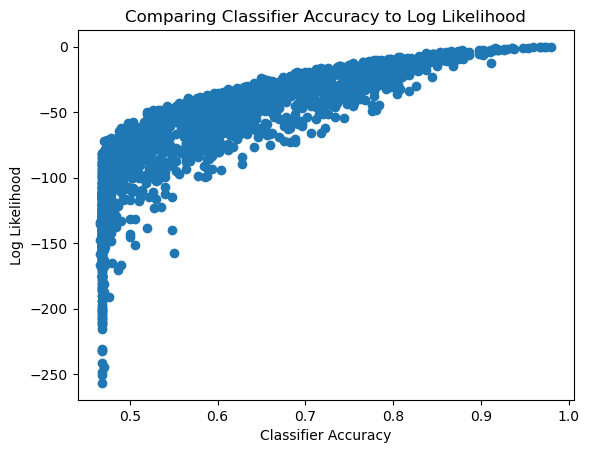

In [27]:
#Plot of Log Likelihood Scores
scores = []
accs = []
for i in 1:10000
    (trace,) = generate(blr, (x_test, y_test, f_test),obs)
    predβ = trace[:β]
    predf = make_poly(predβ)
    pred_labels = data_labeller(x_test,y_test,predf)
    acc = sum([trace[(:z,i)] == pred_labels[i] for i=1:length(labels)])/length(x_test)
    score = get_score(trace)/length(x_test)
    push!(scores,score)
    push!(accs,acc)
end

scatter(accs,scores)
plt.title("Comparing Classifier Accuracy to Log Likelihood")
plt.xlabel("Classifier Accuracy")
plt.ylabel("Log Likelihood");

In [7]:
#Fine then, I'll make my own damn MCMC Algorithm
iterations = 200000
burnin = 2000

#Make initial trace
(trace,) = generate(blr, (x_test, y_test, f_test),obs)
traces = []
accepted = []
for i=1:iterations
    (trace2,) = generate(blr, (x_test, y_test, f_test),obs)
    score1 = exp(get_score(trace)/length(x_test))
    score2 = exp(get_score(trace2)/length(x_test))
    
    score = score2/score1
    
    if score > 1
        trace = trace2
        acc = 1
    else
        if score > rand(Uniform(0,1))
            trace = trace2
            acc = 1
        else
            acc = 0
        end
    end
    if i%20000 == 0    
        println("Epoch $i Acceptance Prob: $(sum(accepted)/length(accepted))")
    end
    push!(accepted, acc)
    if i%1 == 0
        push!(traces, trace)
    end
end

print(sum(accepted)/length(accepted))

Epoch 20000 Acceptance Prob: 0.001400070003500175
Epoch 40000 Acceptance Prob: 0.0013250331258281456
Epoch 60000 Acceptance Prob: 0.0016000266671111186
Epoch 80000 Acceptance Prob: 0.0018250228127851599
Epoch 100000 Acceptance Prob: 0.0018800188001880018
Epoch 120000 Acceptance Prob: 0.0017916815973466446
Epoch 140000 Acceptance Prob: 0.0017785841327438053
Epoch 160000 Acceptance Prob: 0.0018875117969487309
Epoch 180000 Acceptance Prob: 0.0018055655864754805
Epoch 200000 Acceptance Prob: 0.0018000090000450002
0.0018

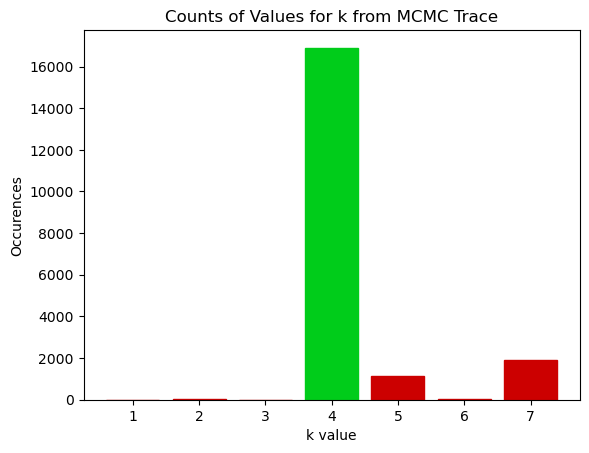

In [29]:
#Bar Plot of k estimates
ks = [traces[i][:k] for i in 1:length(traces)]
counts = [sum([ks[i] == j for i in 1:length(ks)]) for j in k_list]
barlist=bar(k_list,counts)
for i in 1:k_range
    barlist[i].set_color([0.8,0.0,0.0])
end
barlist[4].set_color([0.0,0.8,0.1])

plt.title("Counts of Values for k from MCMC Trace")
plt.xlabel("k value")
plt.ylabel("Occurences");

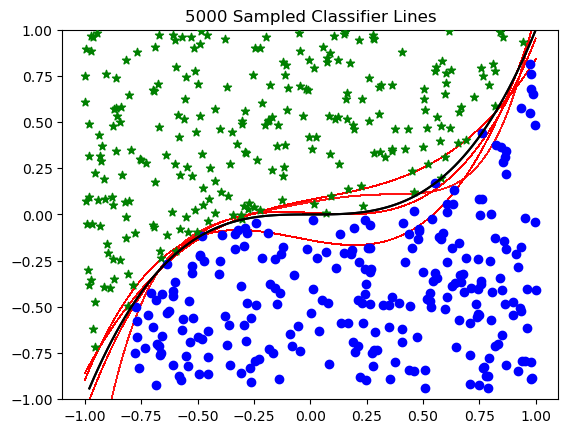

In [28]:
#Sample the markov chain and plot polynomials
plot_data(x_test,y_test,f_test)
for i in 1:2000
    j = rand(5000:length(traces))
    new_f = make_poly(traces[j][:β]) 
    plot_poly(new_f,"red",0.005,1)
end
plot_poly(f_test,"black",1.0)

plt.title("5000 Sampled Classifier Lines");

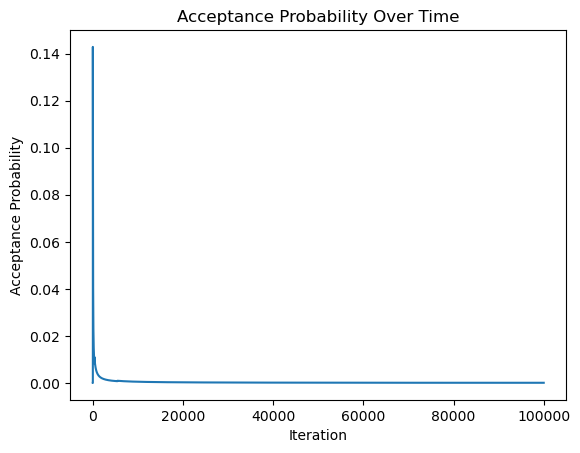

PyObject Text(24.00000000000002, 0.5, 'Acceptance Probability')

In [12]:
#Acceptance Probability Over Time
acc = [sum(accepted[1:i])/i for i in 1:length(accepted)]
plot(acc)
plt.title("Acceptance Probability Over Time")
plt.xlabel("Iteration")
plt.ylabel("Acceptance Probability")

In [27]:
#Metropolis-Hastings finally works!
function mh_inference(iters)
    (trace,) = generate(blr, (x_test, y_test, f_test), obs)
    acc = []
    traces = []
    for i=1:iters
        (trace, accepted) = mh(trace, select(:k,:β), check=false, observations=obs)
        push!(traces, trace)
        push!(acc, accepted)
        if i%20000 == 0
            println(sum(accepted)/length(accepted))
        end
    end
    return traces, acc
end

traces, accepted = mh_inference(20000);

0.0


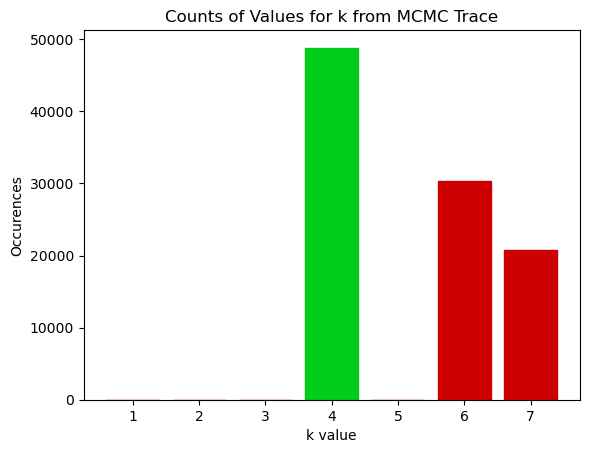

In [11]:
#Bar Plot of k estimates
ks = [traces[i][:k] for i in 1:length(traces)]
counts = [sum([ks[i] == j for i in 1:length(ks)]) for j in k_list]
barlist=bar(k_list,counts)
for i in 1:k_range
    barlist[i].set_color([0.8,0.0,0.0])
end
barlist[4].set_color([0.0,0.8,0.1])

plt.title("Counts of Values for k from MCMC Trace")
plt.xlabel("k value")
plt.ylabel("Occurences");

In [30]:
#Attempt HMC (must fix K to correct value for now)
function hmc_inference(iters)
    (trace,) = generate(blr, (x_test, y_test, f_test), obs)
    acc = []
    traces = []
    for i=1:iters
        (trace, accepted) = hmc(trace, select(:β), L=10, eps=0.2, check=false, observations=obs)
        push!(traces, trace)
        push!(acc, accepted)
        if accepted
            println("Yes")
        end
        if i%100 == 0
            println(sum(accepted)/length(accepted))
        end
    end
    return traces, acc
end

traces, accepted = hmc_inference(1000);

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


In [85]:
selection = select(:β)

prev_model_score = get_score(trace)
#print(prev_model_score)
args = get_args(trace)
retval_grad = accepts_output_grad(get_gen_fn(trace)) ? zero(get_retval(trace)) : nothing
print(accepts_output_grad(get_gen_fn(trace)))
#print(retval_grad)
arg_diffs = map((_) -> NoChange(), args)

new_trace = trace
(_, values_trie, gradient_trie) = choice_gradients(new_trace, selection, retval_grad)
values = to_array(values_trie, Float64)
gradient = to_array(gradient_trie, Float64)

false

4-element Array{Float64,1}:
 NaN
 NaN
 NaN
 NaN

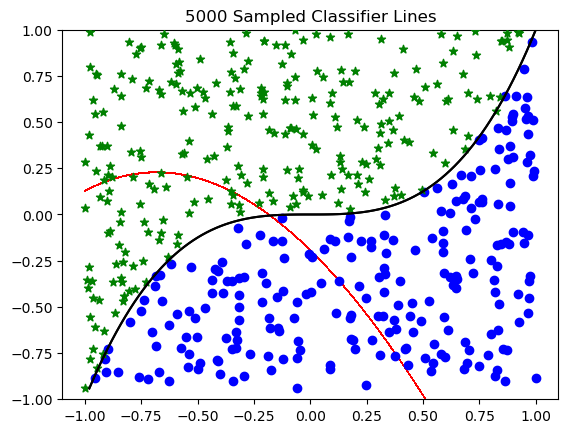

In [21]:
#Plot HMC Results
plot_data(x_test,y_test,f_test)
for i in 1:2000
    j = rand(2000:length(traces))
    new_f = make_poly(traces[j][:β]) 
    plot_poly(new_f,"red",0.005,1)
end
plot_poly(f_test,"black",1.0)

plt.title("5000 Sampled Classifier Lines");

In [101]:
@gen function test()
    γ ~ normal(0,1)
    return γ
end;
accepts_output_grad(test)

false